<a href="https://colab.research.google.com/github/megmarv/AI-BioLabs/blob/Diabetes-Early-Detection/RandomForestModelForEarlyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
import joblib
import shap
import random

In [ ]:
# Load the balanced dataset
df = pd.read_csv('/content/drive/MyDrive/cleaned_balanced_diabetes_data.csv')

In [ ]:
# Step 1: Add interaction terms for key symptom pairs
df['Polyuria_Polydipsia'] = df['Polyuria_encoded'] * df['Polydipsia_encoded']
df['Polyuria_sudden_weight_loss'] = df['Polyuria_encoded'] * df['sudden weight loss_encoded']

# Separate features (X) and target (y)
X = df.drop(columns=['class_encoded'])
y = df['class_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Step 2: Fine-tune Random Forest using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring={'auc': 'roc_auc', 'recall_neg': 'recall'},
    refit='auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)
print(f"Best AUC-ROC Score (Cross-Validation): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters from GridSearchCV:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best AUC-ROC Score (Cross-Validation): 0.9978


In [ ]:
# Step 3: Train the best model on the full training set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Step 4: Evaluate on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

In [ ]:
joblib.dump(best_rf, 'random_forest_diabetes_model.pkl')
print("\nModel saved as 'random_forest_diabetes_model.pkl'")


Model saved as 'random_forest_diabetes_model.pkl'


In [ ]:
# Classification report
print("\nClassification Report (Tuned Model with Interaction Terms):")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report (Tuned Model with Interaction Terms):
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.98        64
    Positive       0.97      0.98      0.98        64

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



In [ ]:
# AUC-ROC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.9993


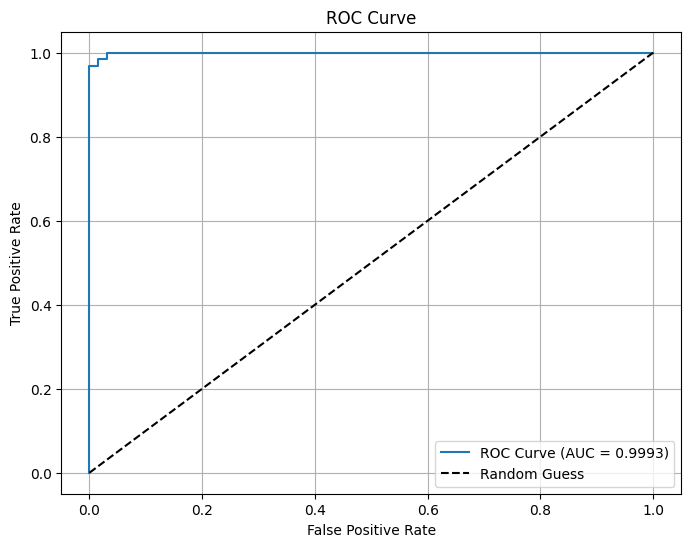

In [ ]:
# Step 5: Visualization 1 - ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('roc_curve.png')

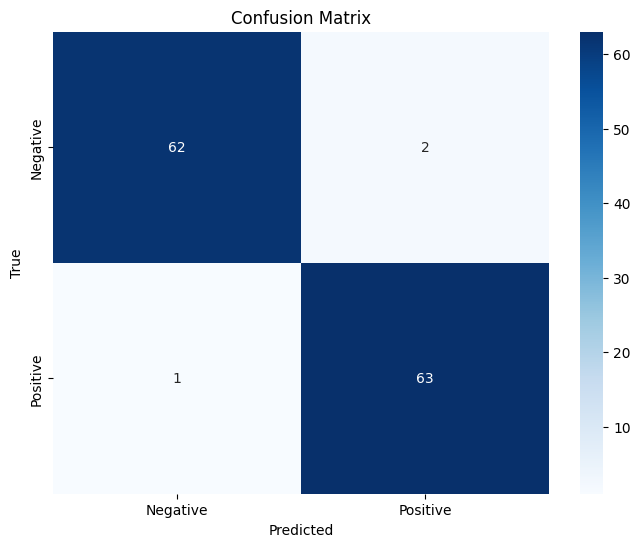

In [ ]:
# Step 6: Visualization 2 - Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

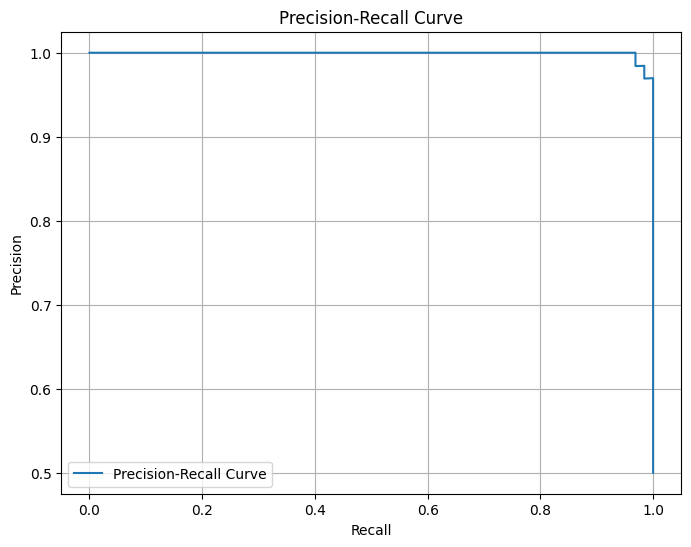

In [ ]:
# Step 7: Visualization 3 - Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('precision_recall_curve.png')

In [ ]:
# Step 8: Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                        Feature  Importance
0              Polyuria_encoded    0.165855
1            Polydipsia_encoded    0.162395
14               Gender_encoded    0.118574
16          Polyuria_Polydipsia    0.096471
17  Polyuria_sudden_weight_loss    0.057801
10      partial paresis_encoded    0.052764
2    sudden weight loss_encoded    0.047570
12             Alopecia_encoded    0.037715
15                  Age_encoded    0.036869
9       delayed healing_encoded    0.033196
7               Itching_encoded    0.030043
4            Polyphagia_encoded    0.028727
8          Irritability_encoded    0.026900
6       visual blurring_encoded    0.025566
11     muscle stiffness_encoded    0.022839
5        Genital thrush_encoded    0.022063
3              weakness_encoded    0.018626
13              Obesity_encoded    0.016025


In [ ]:
# Step 9: Compare with a model without interaction terms
X_no_interaction = df.drop(columns=['class_encoded', 'Polyuria_Polydipsia', 'Polyuria_sudden_weight_loss'])
X_train_no_int, X_test_no_int, y_train_no_int, y_test_no_int = train_test_split(
    X_no_interaction, y, test_size=0.2, random_state=42, stratify=y
)

rf_no_interaction = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_no_interaction.fit(X_train_no_int, y_train_no_int)

y_pred_no_int = rf_no_interaction.predict(X_test_no_int)
y_pred_proba_no_int = rf_no_interaction.predict_proba(X_test_no_int)[:, 1]

In [ ]:
print("\nClassification Report (Tuned Model without Interaction Terms):")
print(classification_report(y_test_no_int, y_pred_no_int, target_names=['Negative', 'Positive']))


Classification Report (Tuned Model without Interaction Terms):
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.98        64
    Positive       0.97      1.00      0.98        64

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



In [ ]:
auc_no_int = roc_auc_score(y_test_no_int, y_pred_proba_no_int)
print(f"AUC-ROC (without Interaction Terms): {auc_no_int:.4f}")

AUC-ROC (without Interaction Terms): 0.9993


In [ ]:
# Step 1: Load the saved model
model = joblib.load('random_forest_diabetes_model.pkl')
print("Loaded the saved Random Forest model from 'random_forest_diabetes_model.pkl'")

Loaded the saved Random Forest model from 'random_forest_diabetes_model.pkl'


In [ ]:
# Step 2: Select a random sample from the dataset
random_idx = random.randint(0, len(df) - 1)
sample = df.iloc[[random_idx]]  # Keep all columns, including class_encoded
features = sample.drop(columns=['class_encoded'])  # Features for prediction
true_label = sample['class_encoded'].iloc[0]  # True label

In [ ]:
# Step 3: Make a prediction
predicted_label = model.predict(features)[0]
predicted_proba = model.predict_proba(features)[0]

In [ ]:
# Convert labels to human-readable form
class_names = ['Negative', 'Positive']
true_label_name = class_names[true_label]
predicted_label_name = class_names[predicted_label]

# Determine if the prediction was correct
prediction_correct = true_label == predicted_label

In [ ]:
# Step 4: Display the full sample (all columns and rows)
print("\nSelected Sample (Full Row):")
print(sample.to_string(index=False))


Selected Sample (Full Row):
 Polyuria_encoded  Polydipsia_encoded  sudden weight loss_encoded  weakness_encoded  Polyphagia_encoded  Genital thrush_encoded  visual blurring_encoded  Itching_encoded  Irritability_encoded  delayed healing_encoded  partial paresis_encoded  muscle stiffness_encoded  Alopecia_encoded  Obesity_encoded  Gender_encoded  Age_encoded  class_encoded  Polyuria_Polydipsia  Polyuria_sudden_weight_loss
                1                   1                           1                 1                   1                       0                        1                1                     1                        1                        1                         1                 0                0               1            1              1                    1                            1


In [ ]:
# Step 5: Display prediction details
print("\nPrediction Details:")
print(f"True Label: {true_label_name}")
print(f"Predicted Label: {predicted_label_name}")
print(f"Prediction Correct: {prediction_correct}")
print(f"Prediction Probabilities: Negative = {predicted_proba[0]:.4f}, Positive = {predicted_proba[1]:.4f}")


Prediction Details:
True Label: Positive
Predicted Label: Positive
Prediction Correct: True
Prediction Probabilities: Negative = 0.0000, Positive = 1.0000


In [ ]:
# Step 6: Text-based visualization for prediction probabilities
print("\nPrediction Probabilities (Text-Based Visualization):")
max_bar_length = 50  # Maximum length of the bar in characters
for i, (class_name, prob) in enumerate(zip(class_names, predicted_proba)):
    bar_length = int(prob * max_bar_length)
    bar = '█' * bar_length + '-' * (max_bar_length - bar_length)
    print(f"{class_name:<10} | {bar} {prob:.4f}")


Prediction Probabilities (Text-Based Visualization):
Negative   | -------------------------------------------------- 0.0000
Positive   | ██████████████████████████████████████████████████ 1.0000


In [ ]:
# Step 16: Text-based visualization for SHAP feature contributions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

# Extract SHAP values for the Positive class (index 1)
shap_values_positive = shap_values[1][0]  # Shape (1, n_features) -> (n_features,)
shap_df = pd.DataFrame({
    'Feature': features.columns,
    'SHAP Value': shap_values_positive
}).sort_values(by='SHAP Value', key=abs, ascending=False)

print("\nSHAP Feature Contributions for Test Sample (Predicted: {}):".format(predicted_label_name))
print(shap_df.to_string(index=False))

In [ ]:
import pandas as pd
import joblib
import numpy as np

# Define the features expected by the model (excluding interaction terms and class_encoded)
FEATURES = [
    'Age', 'Gender_encoded', 'Polyuria_encoded', 'Polydipsia_encoded',
    'sudden weight loss_encoded', 'weakness_encoded', 'Polyphagia_encoded',
    'Genital thrush_encoded', 'visual blurring_encoded', 'Itching_encoded',
    'Irritability_encoded', 'delayed healing_encoded', 'partial paresis_encoded',
    'muscle stiffness_encoded', 'Alopecia_encoded', 'Obesity_encoded'
]

# Friendly descriptions for each feature
FEATURE_DESCRIPTIONS = {
    'Age': 'your age (a positive number, e.g., 45)',
    'Gender_encoded': 'your gender (0 for Female, 1 for Male)',
    'Polyuria_encoded': 'frequent urination (Polyuria)',
    'Polydipsia_encoded': 'excessive thirst (Polydipsia)',
    'sudden weight loss_encoded': 'sudden weight loss',
    'weakness_encoded': 'general weakness or fatigue',
    'Polyphagia_encoded': 'excessive hunger (Polyphagia)',
    'Genital thrush_encoded': 'genital thrush (a yeast infection in the genital area)',
    'visual blurring_encoded': 'blurred vision',
    'Itching_encoded': 'persistent itching',
    'Irritability_encoded': 'irritability or mood swings',
    'delayed healing_encoded': 'delayed healing of wounds',
    'partial paresis_encoded': 'partial paralysis or muscle weakness (Partial Paresis)',
    'muscle stiffness_encoded': 'muscle stiffness',
    'Alopecia_encoded': 'hair loss (Alopecia)',
    'Obesity_encoded': 'obesity (being significantly overweight)'
}

# Load the saved Random Forest model
try:
    model = joblib.load('/content/drive/MyDrive/random_forest_diabetes_model.pkl0')
    print("Model loaded successfully from 'random_forest_diabetes_model.pkl'")
except FileNotFoundError:
    print("Error: Model file 'random_forest_diabetes_model.pkl' not found.")
    exit(1)

# Function to validate binary input (0 or 1)
def get_binary_input(feature, description):
    while True:
        try:
            prompt = f"Do you have {description}? (Enter 0 for No, 1 for Yes): "
            if feature == 'Gender_encoded':
                prompt = f"What is {description}? (Enter 0 for Female, 1 for Male): "
            value = int(input(prompt))
            if value in [0, 1]:
                return value
            else:
                print("Please enter 0 or 1.")
        except ValueError:
            print("Invalid input. Please enter a number (0 for No, 1 for Yes).")

# Function to validate age input (positive integer)
def get_age_input():
    while True:
        try:
            age = int(input("What is your age? (Enter a positive number, e.g., 45): "))
            if age > 0:
                return age
            else:
                print("Please enter a positive number for age.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

# Introduction for the user
print("\nWelcome to the Diabetes Prediction Tool!")
print("This tool will ask you a series of questions about your age, gender, and symptoms.")
print("Based on your answers, it will predict whether you are likely to have diabetes.")
print("For most questions, please answer with 0 for No or 1 for Yes.")
print("Let's get started!\n")

# Prompt user for input
print("Please answer the following questions:")
input_data = {}
for feature in FEATURES:
    description = FEATURE_DESCRIPTIONS[feature]
    if feature == 'Age':
        input_data[feature] = get_age_input()
    else:
        input_data[feature] = get_binary_input(feature, description)

# Compute interaction terms
input_data['Polyuria_Polydipsia'] = input_data['Polyuria_encoded'] * input_data['Polydipsia_encoded']
input_data['Polyuria_sudden_weight_loss'] = input_data['Polyuria_encoded'] * input_data['sudden weight loss_encoded']

# Create a DataFrame for the input
input_df = pd.DataFrame([input_data])

# Ensure the DataFrame has the same feature order as the training data
# Add missing features with default 0 (if any)
model_features = model.feature_names_in_ if hasattr(model, 'feature_names_in_') else FEATURES + ['Polyuria_Polydipsia', 'Polyuria_sudden_weight_loss']
for feature in model_features:
    if feature not in input_df.columns:
        input_df[feature] = 0

# Reorder columns to match model's expected order
input_df = input_df[model_features]

# Make prediction
try:
    predicted_label = model.predict(input_df)[0]
    predicted_proba = model.predict_proba(input_df)[0]
except Exception as e:
    print(f"Error during prediction: {e}")
    exit(1)

# Convert label to human-readable form
class_names = ['Negative', 'Positive']
predicted_label_name = class_names[predicted_label]

# Display results
print("\nPrediction Result:")
print(f"Diabetes Diagnosis Prediction: {predicted_label_name}")
if predicted_label_name == 'Positive':
    print("This means the model predicts you may have diabetes.")
else:
    print("This means the model predicts you are unlikely to have diabetes.")
print("\nPrediction Probabilities:")
print(f"  Likelihood of Negative (No diabetes): {predicted_proba[0]:.4f}")
print(f"  Likelihood of Positive (Has diabetes): {predicted_proba[1]:.4f}")

# Text-based visualization for probabilities
print("\nPrediction Probabilities Visualization:")
max_bar_length = 50
for class_name, prob in zip(class_names, predicted_proba):
    bar_length = int(prob * max_bar_length)
    bar = '█' * bar_length + '-' * (max_bar_length - bar_length)
    label = "Negative (No diabetes)" if class_name == 'Negative' else "Positive (Has diabetes)"
    print(f"{label:<25} | {bar} {prob:.4f}")

print("\nNote: This prediction is based on a machine learning model and should not replace professional medical advice.")
print("Please consult a healthcare provider for an accurate diagnosis.")

Model loaded successfully from 'random_forest_diabetes_model.pkl'

Welcome to the Diabetes Prediction Tool!
This tool will ask you a series of questions about your age, gender, and symptoms.
Based on your answers, it will predict whether you are likely to have diabetes.
For most questions, please answer with 0 for No or 1 for Yes.
Let's get started!

Please answer the following questions:
What is your age? (Enter a positive number, e.g., 45): 45
What is your gender (0 for Female, 1 for Male)? (Enter 0 for Female, 1 for Male): 1
Do you have frequent urination (Polyuria)? (Enter 0 for No, 1 for Yes): 0
Do you have excessive thirst (Polydipsia)? (Enter 0 for No, 1 for Yes): 0
Do you have sudden weight loss? (Enter 0 for No, 1 for Yes): 0
Do you have general weakness or fatigue? (Enter 0 for No, 1 for Yes): 0
Do you have excessive hunger (Polyphagia)? (Enter 0 for No, 1 for Yes): 0
Do you have genital thrush (a yeast infection in the genital area)? (Enter 0 for No, 1 for Yes): 1
Do you hav